In [ ]:
import requests
import re
from bs4 import BeautifulSoup
import string
from time import sleep
from collections import namedtuple
 
urls = [
    'https://www.gutenberg.org/cache/epub/9902/pg9902.html', # The Middle of Things
    'https://www.gutenberg.org/cache/epub/9807/pg9807.html', # Scarhaven Keep
    'https://www.gutenberg.org/cache/epub/9834/pg9834.html', # The Talleyrand Maxim
    'https://www.gutenberg.org/cache/epub/10373/pg10373.html', # The Middle Temple Murder
    'https://www.gutenberg.org/cache/epub/10443/pg10443.html', # The Rayner-Slade Amalgamation
    'http://www.gutenberg.org/cache/epub/12239/pg12239.html', #Dead Men's Money
]

In [ ]:
# Causes output text to wrap in output cells
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
Match = namedtuple('Match', ['chapter_number', 'sentence_number', 'matches', 'text'])


class Scraper:
    def __init__(self, urls):
        self.urls = urls

    def scrape(self, *, responses=None):
        books = []
        responses = [requests.get(url) for url in self.urls] if responses is None else responses

        for response in responses:

            positions = [
                         response.text.find("***END"),
                         response.text.find("THE END")
                        ]
            end_pos = min([pos for pos in positions if pos > 0])
            book_html = response.text[:end_pos]

            def search(pattern):
                return re.search(pattern, book_html).group(1)

            title = search('Title: ([^\<]*)')
            author = search('Author: ([^\<]*)')
            release = search('Release Date: ([A-Za-z]*[\s0-9]*?, [0-9]*)')

            soup = BeautifulSoup(book_html)

            chapters = self.find_chapters(soup)

            books.append(Book(author, chapters, release, title))

        return books

    def find_chapters(self, soup):
        chapters = []
        chapter_tags = soup.find_all(
            re.compile("(h2|h3)"),
            string=re.compile("CHAPTER")
        )
        for chapter_number, chapter_tag in enumerate(chapter_tags, start=1):
            chapter_text = []
            chapter_title = None
            for i, sibling in enumerate(chapter_tag.next_siblings):
                if i == 1:
                    chapter_title = string.capwords(sibling.text)
                elif sibling.name == 'p':
                    chapter_text.append(sibling.text)
                elif sibling.name == 'h2':
                    break
                else:
                    continue

            chapters.append(
                Chapter(chapter_title, chapter_number, chapter_text)
            )

        return chapters

class Chapter:
    def __init__(self, title, number, text):
        self.title = title
        self.number = number
        self.text = self.clean(text)

    def find(self, pattern):
        all_matches = []
        for sentence_number, sentence in self.sentences:
            matches = list(re.finditer(pattern, sentence))
            if len(matches):
                all_matches.append(
                    Match(self.number, sentence_number, matches, sentence)
                )

        return all_matches

    @staticmethod
    def clean(chapter_text):
        chapter_text = ' '.join(chapter_text)
        chapter_text = chapter_text.replace('\r\n', ' ')
        return chapter_text

    @property
    def sentences(self):
        '''
        Splits the chapter text into sentences. This is a hard task so some decisions need to be made.

        Case 1: (?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<![A-Z][a-z][a-z]\.)(?<=[.?!])\s
            (?<!\w\.\w.): Negative lookbehind to prevent splitting on i.e. and e.g.
        Python requires fixed width patterns for lookbehinds, so we have split these
            (?<![A-Z][a-z]\.): Negative lookbehind to prevent splitting on Mr.
            (?<![A-Z][a-z][a-z]\.): Negative lookbehind to prevent splitting on Mrs.
            (?<=[.?!]): Positive lookbehing to make sure we're only splitting after ., ?, or !
            \s: Any white-space character
        Case 2: (?<=[.?!][\"])\s(?=[\"A-Z])
            (?<=[.?!][\"]): Positive lookbehind to make sure we're only splitting after .", ?", or !"
            \s: Any white-space character
            (?=[\"A-Z]): Positive lookahead to make sure we're only splitting before " or a capital letter

        Examples:
            ...a fashion which had become a habit. Miss Penkridge...
                Sentence 1: ...a fashion which had become a habit.
                Sentence 2: Miss Penkridge...
            ...content. "So he did it! Now, I should never have thought it! The last person...
                Sentence 1: ...content.
                Sentence 2: "So he did it!
                Sentence 3: Now, I should never have thought it!
                Sentence 4: The last person...
            ...this sort of stuff?" "Stuff?" demanded Miss Penkridge, who had resumed her...
                Sentence 1: ...this sort of stuff?"
                Sentence 2: "Stuff?" demanded Miss Penkridge, who had resumed her...
        '''
        splits = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<![A-Z][a-z][a-z]\.)(?<=[.?!;])\s|(?<=[.?!][\"])\s(?=[\"A-Z])', self.text)
        return zip(range(1, len(splits)+1), splits)

    def __len__(self):
        return len(list(self.sentences))

    def __str__(self):
        return self.title

    def __repr__(self):
        return (
            f'Chapter {self.number}: {self.title}\n'
            f'Content: {self.text[:20]}...{self.text[-20:]}'
        )

class Book:
    def __init__(self, author, chapters, release, title):
        self.author = author
        self.chapters = chapters
        self.release = release
        self.title = title

    def find(self, pattern):
        all_matches = []
        for chapter in self.chapters:
            matches = chapter.find(pattern)
            if len(matches):
                all_matches.extend(matches)

        return all_matches

    def __len__(self):
        return len(self.chapters)

    def __str__(self):
        return self.title

    def __repr__(self):
        return (
            f'{self.title} by {self.author}, '
            f'released in {self.release} and '
            f'contains {len(self)} chapters.'
        )

In [ ]:
# For debugging
responses = [requests.get(url) for url in urls]

In [ ]:
scraper = Scraper(urls)
#books = scraper.scrape(responses=responses[:1])
books = scraper.scrape()


In [ ]:
print(len(books))
for book in books:
    print(f"Book: {book.title}, {len(book)} Chapters")
    nsentences=0
    length=0
    for chapter in book.chapters:
        nsentences+=len(chapter)
        length+=len(chapter.text)
        #nl = '\n'
        #print(f"    Chapter {chapter.number}: {chapter.title} #sentences:{len(chapter)} len(text)={len(chapter.text)}")
        #print(f"        ")
        #for sent in chapter.sentences:
        #    print(sent[1])
        #print(chapter.text[:400])
    print(f" #sentences {nsentences} length {length}")

6
Book: The Middle of Things, 29 Chapters
 #sentences 5026 length 408290
Book: Scarhaven Keep, 31 Chapters
 #sentences 4900 length 414897
Book: The Talleyrand Maxim, 28 Chapters
 #sentences 5047 length 415046
Book: The Middle Temple Murder, 36 Chapters
 #sentences 5459 length 405828
Book: The Rayner-Slade Amalgamation, 35 Chapters
 #sentences 5271 length 442761
Book: Dead Men's Money, 37 Chapters
 #sentences 4144 length 406024


In [ ]:
import nltk.data
import nltk
import nltk.corpus
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('english')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")
#nltk.download("taggers")
from nltk.corpus import wordnet
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')


url ="https://nlp.stanford.edu/software/stanford-tagger-4.1.0.zip"
import urllib
import zipfile
import os
filehandle, _ = urllib.request.urlretrieve(url)
os.system("unzip %s"%filehandle)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0

In [ ]:
print(os.listdir("./stanford-postagger-full-2020-08-06"))
os.environ["STANFORD_MODELS"]="./stanford-postagger-full-2020-08-06/models/"
stanford_tagger_path = "english-bidirectional-distsim.tagger"

['build.xml', 'LICENSE.txt', 'data', 'TaggerDemo.java', 'stanford-postagger.jar', 'sample-output.txt', 'stanford-postagger-4.1.0.jar', 'TaggerDemo2.java', 'stanford-postagger-4.1.0-javadoc.jar', 'stanford-postagger-gui.sh', 'stanford-postagger-gui.bat', 'models', 'stanford-postagger.bat', 'stanford-postagger.sh', 'stanford-postagger-4.1.0-sources.jar', 'README.txt', 'sample-input.txt']


In [ ]:
from nltk.tokenize.treebank import TreebankWordTokenizer
from collections import defaultdict, Counter
import string
translator = str.maketrans('', '', string.punctuation)
tokenizer = TreebankWordTokenizer()

def getCharactersNLTK(book):
  print(f"Book: {book.title}, {len(book)} Chapters")
  wordFrequencies = Counter()
  for chapter in book.chapters:
    for sentence_num, sentence in chapter.sentences:
      # remove punctuation
      sentence = str(sentence).translate(translator)
      # uses treebank tokenizer (aka a complex regex)
      words = tokenizer.tokenize(sentence)
      for word,pos in nltk.pos_tag(words):
        # only keep proper nouns
        if pos!="NNP":continue
        wordFrequencies[word]+=1
  characterList = Counter()
  for word in wordFrequencies:
    if wordFrequencies[word] > 10 and word[0].isupper(): characterList[word]=wordFrequencies[word]
  return characterList

def getMurderOccurrencesNLTK(book):
  print(f"Book: {book.title}, {len(book)} Chapters")
  chapterWordFrequencies = defaultdict(Counter)
  murderOccurrences = set()
  synset = wordnet.synsets("murder")
  murder_n,murder_v,mangle = synset
  for chapter in book.chapters:
    chapter_number = chapter.chapter_number
    for sentence_num, sentence in chapter.sentences:
      # remove punctuation
      sentence = str(sentence).translate(translator)
      # uses treebank tokenizer (aka a complex regex)
      words = tokenizer.tokenize(sentence)
      for word,pos in nltk.pos_tag(words):
        # remove stopwords
        syn = wordnet.synsets(word)
        for i in syn:
          if i==murder_n or i==murder_v:
            word="murder"
        if word =="murder": pass
        else:continue
        murderOccurrences.add( (chapter_number,sentence_number) )
  return murderOccurrences

def getSurroundingWordsNLTK(book, word):
  #print(f"Book: {book.title}, {len(book)} Chapters")
  wordContext = Counter()
  for chapter in book.chapters:
    chapter_number = chapter.number
    for sentence_num, sentence in chapter.sentences:
      # remove punctuation
      sentence = str(sentence).translate(translator)
      # uses treebank tokenizer (aka a complex regex)
      words = tokenizer.tokenize(sentence)
      words = [i for i in words if i not in stopwords]
      for i in range(0,len(words)):
        if word == words[i]:
          for j in range(i-3,i+4):
            if j<0 or j>=len(words) or i==j:continue 
            wordContext[(word,words[j])]+=1
  if len(wordContext)==0:
    print(f"Unable to find {word} in {book}")
  return wordContext

In [ ]:
scraper = Scraper(urls)
books = scraper.scrape(responses=responses)

all_matches = books[0].find("Ashton")
for match in all_matches:
    print(f'Found a match in Chapter {match.chapter_number}, Sentence {match.sentence_number}')
    print(f'Sentence Text: {match.text}')
    print(match.matches[0].group(0))
    break

Found a match in Chapter 2, Sentence 36
Sentence Text: "Mr. Ashton!"
Ashton


In [ ]:
def getCooccurrences(book, *words):
  sets = []
  for word in words:
    wordMatches = set()
    matches = book.find(word)
    for match in matches:
      wordMatches.add( (match.chapter_number, match.sentence_number) )
    sets.append(wordMatches)
  intersection = sets[0]
  for i in sets:
    intersection = intersection.intersection(i)
  return intersection
  

In [ ]:

book_details = {
    "The Middle of Things": {
        "Detective": "Viner",
        "Perp": "Cortelyon", # text=Cortelyon saw that by killing Ashton he alone would have the secret; he evidently got two accomplices who were necessary to him
        # Cave (Nugent Starr) and Killenhall, his accomplices
        "Crime": "murder", #chapter 1 last sentence. Text=Then he saw white linen, and a bloodstain slowly spreading over its glossy surface.
        "Other Suspects": "Penkridge",
        "Victim": "Richard Ashton",
        "Characters": ['Viner', 'Pawle', 'Ashton', 'Carless', 'Wickham', 'Hyde', #victim
                       'Marketstoke', 'Ellingham', 'Drillford', 'Killenhall', 
                       'Methley', 'Perkwite', 'Miss Wickham', 'Felpham', 
                       'John Ashton', 'Cave', 'Miss Penkridge', 'Fosdick', 
                       'Millington-Bywater', 'Cortelyon', 'Armitstead', 'Barleyfield', # perp
                       'Summers', 'Van Hoeren', 'Millwaters', 'Woodlesford', 'Penkridge', 
                       'Stephens', 'Portlethwaite', 'Martincole', 'Richard', 'Bigglesforth', 
                       'Driver', 'Nugent Starr', 'Avice', 'Pelver', 'Earl', 'Langton Hyde',
                       'Roscombe', 'Langton', 'Lincoln']
    },
    "The Middle Temple Murder" : {
        "Detective": "Spargo|Frank Spargo|Frank", # "Frank Spargo",
        "Perp": "Jane Baylis|Miss Baylis", # Jane Baylis murdered John Maitland
        "Crime": "murder", # john maitland a bank manager charged with embezzlement. changed his name. had a son named Breton. then was killed at cardlestone/Chamberlayne's
        "Other Suspects": "Stephen Aylmore|Chamberlayne|Myerst",
        "Victim": "John Maitland|John Marbury", # john marbury is maitland he changed his name
        "Characters": ['Spargo', 'Breton', 'Marbury', 'Elphick', 'Aylmore', 'Maitland', 
                       'Rathbury', 'Quarterpage', 'Cardlestone', 'Myerst', 'Baylis', 'John Marbury', # victim
                       'John Maitland', 'Ronald Breton', 'Walters', 'Criedir', 'Gutch', 'Driscoll', # victim
                       'Mother Gutch', 'Webster', 'Anderson', 'Jane Baylis', 'Mollison', 'Jessie Aylmore', #perp
                       'Starkey', 'Jessie', 'Stephen Aylmore', 'Evelyn', 'Cooper', 'Ronald', 'Crowfoot', 'Doolittle', 
                       'Ainsworth', 'David Lyell', 'Vallas', 'Kaye', 'Stephens', 'Septimus Elphick', 'Miss Baylis', 
                       'Robertson', 'Lyell']
    },
    "Scarhaven Keep" : {
        "Detective": "Copplestone|Richard Copplestone", 
        "Perp": "Peter Chatfield|Addie Chatfield|Addie|Martin|Andrius|Martin Andrius", # Martin, Addie Chatfield
        "Crime": "fraud", # plot twist. originally they are investigating the murder of basset oliver. this turns out to be an accident not murder.
        "Other Suspects": "Audrey Greyle",
        "Victim": "Audrey Greyle", 
        "Characters": ['Copplestone', 'Greyle', 'Gilling', 'Chatfield', 'Vickers', 
                       'Audrey', 'Marston Greyle', 'Bassett Oliver', 'Cresswell', 'Oliver', # victim
                       'Stafford', 'Petherton', 'Wooler', 'Addie', 'Dennie', 'Cresswell Oliver', 
                       'Peter Chatfield', 'Spurge', 'Andrius', 'Pike', 'Ewbank', 'Addie Chatfield', # perp
                       'Zachary Spurge', 'Scarhaven', 'Squire', 'Jim', 'Peter', 'Altmore', 'Audrey Greyle', 
                       'Bassett', 'Martin', 'Rothwell', 'Montmorency', 'Hackett', 'Miss Greyle', 'Glen', 'Salmon', 
                       'Jerramy', 'Elkin', 'Hobkin', 'Tretheway', 'Valdey', 'Jim Spurge', 'Valentine Greyle', 'Stephen John']
    }, 
    "The Talleyrand Maxim": {
        "Detective": "Linford Pratt|Pratt", # detective commits suicide at the end of the book
        "Perp": "Mallathorpe|Harper|Harper Mallathorpe",
        "Crime": "murder",  # plot twist initially they investigate a murder, but it turns out the man left town and went to america
        #harper destroyed her husband's will because he left his money to a charity
        "Other Suspects": "Nesta",
        "Victim": "John Mallathorpe",
        "Location": "Barford",
        "Characters": ['Pratt', 'Eldrick', 'Collingwood', 'Mallathorpe', # includes the entire mallathrope family
                       'Nesta', 'Parrawhite', 'Murgatroyd', 'John Mallathorpe', #victim 
                       'Pickard', 'Byner', 'Esther Mawson', 'Bartle',
                       'Antony Bartle', 'Cobcroft', 'Prydale', 
                       'Nesta Mallathorpe', 'Harper', 'Robson', 'Normandale Grange',
                       'Esther', 'Linford Pratt', 'Miss Mallathorpe', 'Harper Mallathorpe', # perp
                       'Gaukrodger', 'James Parrawhite', 'Marshall', 'Barford', 'Pascoe', 
                       'Jabey Naylor', 'Parsons', 'Clough', 'Stringer', 
                       'Shepherd', 'Bartle Collingwood']
    },
    "Dead Men's Money": {
        "Detective": "Hugh Moneylaw|Hugh|Moneylaw", # hugh is writing the story in first person
        "Perp": "Gilbert Carstairs|Meekin", # Meek
        "Crime": "murder", # Meekin impersonates Gilbert Carstairs and steals his money. 
        # a few people find out about it and want to be paid off. meekin kills them
        "Other Suspects": "",
        "Victim": "Crone",
        "Characters": ['Lindsey', 'Gilbert', 'Portlethorpe',
                       'Chisholm', 'Gilverthwaite', 'Gilbert Carstairs',
                       'Crone', 'Phillips', 'Maisie', 'Smeaton', 'Murray', #victim
                       'Hugh', 'Hollins', 'Moneylaws', 'Michael Carstairs',
                       'Carstairs', 'Ridley', 'Ralston', 'Gavin Smeaton', 
                       'John Phillips', 'James Gilverthwaite', 'Lady Carstairs',
                       'Peebles', 'Elphinstone', 'Andrew Dunlop', 'Abel Crone',
                       'Michael', 'Paley', 'Hanson', 'Carter', 'Alexander', 
                       'Maisie Dunlop', 'Meekin', 'Nance Maguire', 'Hathercleugh', #perp
                       'Dunlop', 'John Paley', 'Robertson', 'Tom Dunlop', 
                       'Hugh Moneylaws', 'Scott', 'Watson', 'Martin Smeaton', 
                       'Turndale']
    }
}

for book in books:
  if "Amalgamation" in book.title: continue
  characters = book_details[book.title]["Characters"]
  print(book)
  print(characters)



The Middle of Things
['Viner', 'Pawle', 'Ashton', 'Carless', 'Wickham', 'Hyde', 'Marketstoke', 'Ellingham', 'Drillford', 'Killenhall', 'Methley', 'Perkwite', 'Miss Wickham', 'Felpham', 'John Ashton', 'Cave', 'Miss Penkridge', 'Fosdick', 'Millington-Bywater', 'Cortelyon', 'Armitstead', 'Barleyfield', 'Summers', 'Van Hoeren', 'Millwaters', 'Woodlesford', 'Penkridge', 'Stephens', 'Portlethwaite', 'Martincole', 'Richard', 'Bigglesforth', 'Driver', 'Nugent Starr', 'Avice', 'Pelver', 'Earl', 'Langton Hyde', 'Roscombe', 'Langton', 'Lincoln']
Scarhaven Keep
['Copplestone', 'Greyle', 'Gilling', 'Chatfield', 'Vickers', 'Audrey', 'Marston Greyle', 'Bassett Oliver', 'Cresswell', 'Oliver', 'Stafford', 'Petherton', 'Wooler', 'Addie', 'Dennie', 'Cresswell Oliver', 'Peter Chatfield', 'Spurge', 'Andrius', 'Pike', 'Ewbank', 'Addie Chatfield', 'Zachary Spurge', 'Scarhaven', 'Squire', 'Jim', 'Peter', 'Altmore', 'Audrey Greyle', 'Bassett', 'Martin', 'Rothwell', 'Montmorency', 'Hackett', 'Miss Greyle', 'Gle

In [ ]:
def getFirstRef(role, name, book):
  matches = book.find(name)
  if len(matches)==0: 
    print(f" {role} {name} not found in book")
    return
  first_ref = matches[0]
  print(f"{role} {name} first referenced chapter {first_ref.chapter_number} sentence {first_ref.sentence_number}")

for book in books:
  if "Amalgamation" in book.title: continue
  print("")
  print(f"Title:{book.title} \n Total Chapters: {len(book.chapters)}")
  print("#"*30)
  characters = book_details[book.title]["Characters"]
  # get first mention for Q1
  detective = book_details[book.title]["Detective"]
  getFirstRef("Detective", detective, book)
  # get first mention for Q2
  perp = book_details[book.title]["Perp"]
  getFirstRef("Perp", perp, book)
  # get first mention for Q3
  crime  = book_details[book.title]["Crime"]
  getFirstRef("Crime", crime, book)
  # get the words 3 before an three after perp
  contextWords = Counter()
  for alias in perp.split("|"):
    for name in alias.split(" "):
      contextWords += getSurroundingWordsNLTK(book,name)
  print(f"number of context words {len(contextWords)}")
  top100 = contextWords.most_common(100)
  for (w,c),count in top100:
    print("%s & %s & %s \\"%(w,c,count))
  # get cooccurrences of detective and perp
  cooccurrences = getCooccurrences(book,detective,perp)
  print(f"Detective-perp cooccurrences {sorted(cooccurrences)}")
  # get first mention of other suspects
  otherSuspects = book_details[book.title]["Other Suspects"]
  getFirstRef("Other Suspects",otherSuspects, book)


Title:The Middle of Things 
 Total Chapters: 29
##############################
Detective Viner first referenced chapter 1 sentence 1
Perp Cortelyon first referenced chapter 2 sentence 54
Crime murder first referenced chapter 1 sentence 76
number of context words 91
Cortelyon & Dr & 10 \
Cortelyon & Ashton & 5 \
Cortelyon & hed & 3 \
Cortelyon & asked & 2 \
Cortelyon & square & 2 \
Cortelyon & years & 2 \
Cortelyon & Cave & 2 \
Cortelyon & wed & 2 \
Cortelyon & papers & 2 \
Cortelyon & found & 2 \
Cortelyon & But—theres & 1 \
Cortelyon & somewhere & 1 \
Cortelyon & here—number & 1 \
Cortelyon & seven & 1 \
Cortelyon & What & 1 \
Cortelyon & pushed & 1 \
Cortelyon & front & 1 \
Cortelyon & man & 1 \
Cortelyon & dead & 1 \
Cortelyon & drew & 1 \
Cortelyon & stooping & 1 \
Cortelyon & position & 1 \
Cortelyon & see & 1 \
Cortelyon & comes & 1 \
Cortelyon & along & 1 \
Cortelyon & walked & 1 \
Cortelyon & policestation & 1 \
Cortelyon & came & 1 \
Cortelyon & said & 1 \
Cortelyon & first &

/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Chapter:1 MURDER: 1 Will: 13 MurderSimple: 0 WillSimple:12
Chapter:2 MURDER: 3 Will: 16 MurderSimple: 0 WillSimple:17
Chapter:3 MURDER: 6 Will: 2 MurderSimple: 0 WillSimple:4
Chapter:4 MURDER: 3 Will: 3 MurderSimple: 0 WillSimple:6
Chapter:5 MURDER: 0 Will: 17 MurderSimple: 0 WillSimple:20
Chapter:6 MURDER: 4 Will: 9 MurderSimple: 0 WillSimple:12
Chapter:7 MURDER: 3 Will: 3 MurderSimple: 2 WillSimple:3
Chapter:8 MURDER: 0 Will: 11 MurderSimple: 1 WillSimple:14
Chapter:9 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:3
Chapter:10 MURDER: 5 Will: 1 MurderSimple: 0 WillSimple:4
Chapter:11 MURDER: 2 Will: 0 MurderSimple: 0 WillSimple:7
Chapter:12 MURDER: 4 Will: 2 MurderSimple: 0 WillSimple:7
Chapter:13 MURDER: 0 Will: 1 MurderSimple: 0 WillSimple:2
Chapter:14 MURDER: 0 Will: 0 MurderSimple: 0 WillSimple:5
Chapter:15 MURDER: 2 Will: 0 MurderSimple: 3 WillSimple:7
Chapter:16 MURDER: 2 Will: 0 MurderSimple: 0 WillSimple:2
Chapter:17 MURDER: 4 Will: 0 MurderSimple: 0 WillSimple:6
Chapter:18 MUR

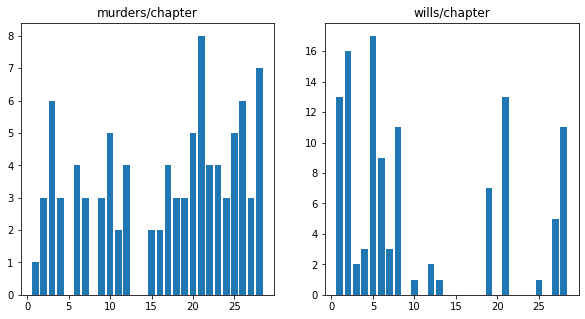

In [ ]:
import matplotlib.pyplot as plt
import tqdm
#import spacy.cli
#spacy.cli.download("en_core_web_sm")
#import spacy 
#nlp = spacy.load("en_core_web_sm")
#from nltk.parse.corenlp import CoreNLPParser
from nltk.tag.stanford import StanfordPOSTagger
st = StanfordPOSTagger('english-bidirectional-distsim.tagger', 'stanford-postagger-full-2020-08-06/stanford-postagger.jar')
#st = CoreNLPParser(url='http://0.0.0.0:9000')
#pos_tagger = CoreNLPParser(url='http://0.0.0.0:9000', tagtype='pos')
#print(st.__dict__)
def countWillByChapter(book):
  c = Counter()
  synset = wordnet.synsets("will")
  will_document = None
  for i in synset: 
    if i.name() == "will.n.03": will_document = i
  #bar = tqdm.tqdm(total=len(book.chapters))
  for chapter in book.chapters:
    chapter_number = chapter.number
    for sentence_num, sentence in chapter.sentences:
      # remove punctuation
      sentence = sentence.replace("John Mallathorpe's", "the")
      sentence = sentence.replace("—"," ")
      #sentence = str(sentence).translate(translator)
      if "will" not in sentence: continue
      # uses treebank tokenizer (aka a complex regex)
      words = tokenizer.tokenize(sentence)
      #for token in nlp(sentence):
      for word,pos in st.tag(words):
        #word = token.text
        #pos = token.pos_
        #if "will" in word: print(word,pos, sentence)
        if pos =="NN" or pos == "NNS" or pos =="NNP": pass
        else: continue
        # remove stopwords
        syn = wordnet.synsets(word)
        for i in syn:
          if i==will_document:
            c[chapter_number]+=1
    #bar.update(1)
  return c

def countMurderByChapter(book):
  c = Counter()
  synset = wordnet.synsets("murder")
  murder_n,murder_v,mangle = synset
  for chapter in book.chapters:
    chapter_number = chapter.number
    for sentence_num, sentence in chapter.sentences:
      # remove punctuation
      sentence = str(sentence).translate(translator)
      # uses treebank tokenizer (aka a complex regex)
      words = tokenizer.tokenize(sentence)
      for word,pos in nltk.pos_tag(words):
        # remove stopwords
        syn = wordnet.synsets(word)
        for i in syn:
          if i==murder_n or i==murder_v:
            c[chapter_number]+=1
  return c

def countByChapter(matches):
  c=Counter()
  for match in matches:
    c[match.chapter_number]+=1
  return c


for book in books:
  murderData = []
  willData = []
  if book.title != "The Talleyrand Maxim":
    continue
  murder = countMurderByChapter(book)
  murderSimple = countByChapter(book.find("murder"))

  will = countWillByChapter(book)
  willSimple = countByChapter(book.find("will"))
  for i in range(1,len(book.chapters)+1):
    murderData.append(murder[i])
    willData.append(will[i])
    print(f"Chapter:{i} MURDER: {murder[i]} Will: {will[i]} MurderSimple: {murderSimple[i]} WillSimple:{willSimple[i]}")
  plt.figure()
  plt.subplot(1,2,1)
  plt.bar(range(1,len(book.chapters)+1), murderData)
  plt.title('murders/chapter')
  # plt.show()
  plt.subplot(1,2,2)
  plt.bar(range(1,len(book.chapters)+1), willData)
  plt.title('wills/chapter')
  plt.show()

Chapter:1 MURDER: 3 Will: 0 MurderSimple: 3 WillSimple:0
Chapter:2 MURDER: 15 Will: 0 MurderSimple: 8 WillSimple:1
Chapter:3 MURDER: 9 Will: 0 MurderSimple: 6 WillSimple:5
Chapter:4 MURDER: 15 Will: 0 MurderSimple: 7 WillSimple:5
Chapter:5 MURDER: 10 Will: 0 MurderSimple: 8 WillSimple:2
Chapter:6 MURDER: 13 Will: 2 MurderSimple: 6 WillSimple:4
Chapter:7 MURDER: 7 Will: 0 MurderSimple: 5 WillSimple:4
Chapter:8 MURDER: 5 Will: 0 MurderSimple: 2 WillSimple:1
Chapter:9 MURDER: 4 Will: 2 MurderSimple: 1 WillSimple:4
Chapter:10 MURDER: 3 Will: 0 MurderSimple: 2 WillSimple:3
Chapter:11 MURDER: 16 Will: 0 MurderSimple: 8 WillSimple:3
Chapter:12 MURDER: 8 Will: 0 MurderSimple: 6 WillSimple:1
Chapter:13 MURDER: 13 Will: 0 MurderSimple: 6 WillSimple:2
Chapter:14 MURDER: 4 Will: 1 MurderSimple: 3 WillSimple:3
Chapter:15 MURDER: 14 Will: 0 MurderSimple: 7 WillSimple:9
Chapter:16 MURDER: 9 Will: 0 MurderSimple: 7 WillSimple:3
Chapter:17 MURDER: 11 Will: 0 MurderSimple: 7 WillSimple:5
Chapter:18 MURD

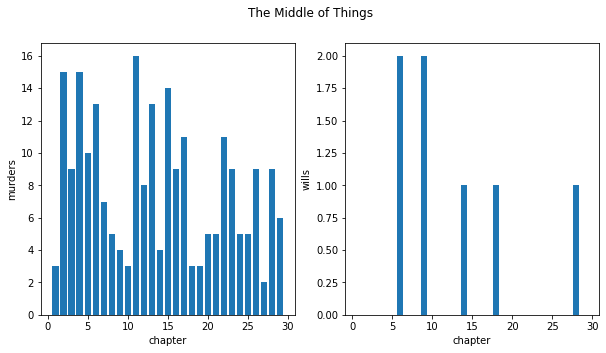

Chapter:1 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:0
Chapter:2 MURDER: 6 Will: 0 MurderSimple: 0 WillSimple:0
Chapter:3 MURDER: 2 Will: 0 MurderSimple: 0 WillSimple:3
Chapter:4 MURDER: 4 Will: 0 MurderSimple: 1 WillSimple:2
Chapter:5 MURDER: 1 Will: 0 MurderSimple: 0 WillSimple:9
Chapter:6 MURDER: 2 Will: 0 MurderSimple: 0 WillSimple:1
Chapter:7 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:8
Chapter:8 MURDER: 6 Will: 0 MurderSimple: 0 WillSimple:4
Chapter:9 MURDER: 2 Will: 0 MurderSimple: 0 WillSimple:0
Chapter:10 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:2
Chapter:11 MURDER: 4 Will: 0 MurderSimple: 0 WillSimple:5
Chapter:12 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:8
Chapter:13 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:3
Chapter:14 MURDER: 6 Will: 0 MurderSimple: 0 WillSimple:3
Chapter:15 MURDER: 5 Will: 0 MurderSimple: 0 WillSimple:7
Chapter:16 MURDER: 7 Will: 0 MurderSimple: 1 WillSimple:1
Chapter:17 MURDER: 5 Will: 0 MurderSimple: 0 WillSimple:4
Chapter:18 MURDER: 2 Wi

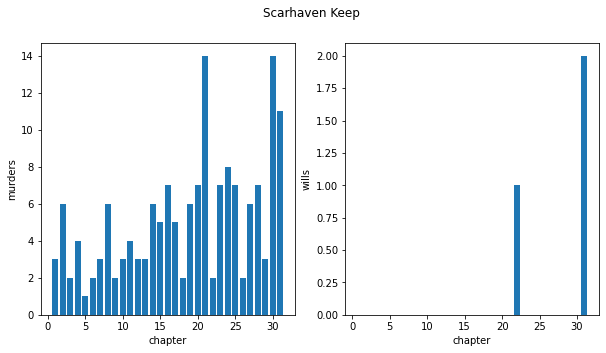

Chapter:1 MURDER: 1 Will: 13 MurderSimple: 0 WillSimple:12
Chapter:2 MURDER: 3 Will: 16 MurderSimple: 0 WillSimple:17
Chapter:3 MURDER: 6 Will: 2 MurderSimple: 0 WillSimple:4
Chapter:4 MURDER: 3 Will: 3 MurderSimple: 0 WillSimple:6
Chapter:5 MURDER: 0 Will: 17 MurderSimple: 0 WillSimple:20
Chapter:6 MURDER: 4 Will: 9 MurderSimple: 0 WillSimple:12
Chapter:7 MURDER: 3 Will: 3 MurderSimple: 2 WillSimple:3
Chapter:8 MURDER: 0 Will: 11 MurderSimple: 1 WillSimple:14
Chapter:9 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:3
Chapter:10 MURDER: 5 Will: 1 MurderSimple: 0 WillSimple:4
Chapter:11 MURDER: 2 Will: 0 MurderSimple: 0 WillSimple:7
Chapter:12 MURDER: 4 Will: 2 MurderSimple: 0 WillSimple:7
Chapter:13 MURDER: 0 Will: 1 MurderSimple: 0 WillSimple:2
Chapter:14 MURDER: 0 Will: 0 MurderSimple: 0 WillSimple:5
Chapter:15 MURDER: 2 Will: 0 MurderSimple: 3 WillSimple:7
Chapter:16 MURDER: 2 Will: 0 MurderSimple: 0 WillSimple:2
Chapter:17 MURDER: 4 Will: 0 MurderSimple: 0 WillSimple:6
Chapter:18 MUR

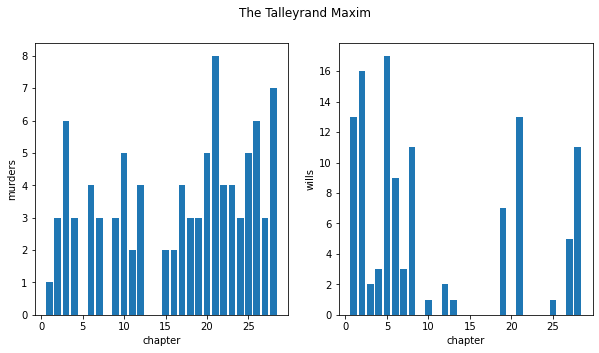

Chapter:1 MURDER: 8 Will: 0 MurderSimple: 5 WillSimple:0
Chapter:2 MURDER: 4 Will: 0 MurderSimple: 2 WillSimple:3
Chapter:3 MURDER: 9 Will: 0 MurderSimple: 4 WillSimple:1
Chapter:4 MURDER: 3 Will: 0 MurderSimple: 1 WillSimple:0
Chapter:5 MURDER: 15 Will: 0 MurderSimple: 7 WillSimple:0
Chapter:6 MURDER: 10 Will: 0 MurderSimple: 7 WillSimple:3
Chapter:7 MURDER: 5 Will: 0 MurderSimple: 1 WillSimple:1
Chapter:8 MURDER: 9 Will: 0 MurderSimple: 8 WillSimple:3
Chapter:9 MURDER: 10 Will: 0 MurderSimple: 5 WillSimple:2
Chapter:10 MURDER: 1 Will: 0 MurderSimple: 0 WillSimple:0
Chapter:11 MURDER: 5 Will: 0 MurderSimple: 1 WillSimple:3
Chapter:12 MURDER: 0 Will: 0 MurderSimple: 1 WillSimple:2
Chapter:13 MURDER: 0 Will: 0 MurderSimple: 1 WillSimple:8
Chapter:14 MURDER: 6 Will: 0 MurderSimple: 3 WillSimple:2
Chapter:15 MURDER: 2 Will: 1 MurderSimple: 0 WillSimple:2
Chapter:16 MURDER: 0 Will: 0 MurderSimple: 0 WillSimple:0
Chapter:17 MURDER: 0 Will: 0 MurderSimple: 0 WillSimple:3
Chapter:18 MURDER: 1

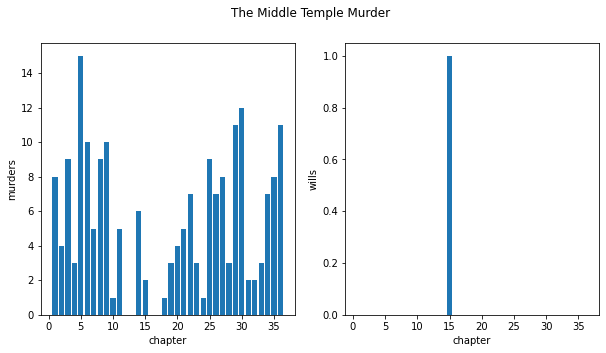

Chapter:1 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:2
Chapter:2 MURDER: 4 Will: 0 MurderSimple: 0 WillSimple:6
Chapter:3 MURDER: 6 Will: 0 MurderSimple: 2 WillSimple:6
Chapter:4 MURDER: 7 Will: 0 MurderSimple: 1 WillSimple:2
Chapter:5 MURDER: 7 Will: 0 MurderSimple: 2 WillSimple:0
Chapter:6 MURDER: 3 Will: 0 MurderSimple: 1 WillSimple:7
Chapter:7 MURDER: 2 Will: 0 MurderSimple: 0 WillSimple:5
Chapter:8 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:3
Chapter:9 MURDER: 4 Will: 0 MurderSimple: 3 WillSimple:2
Chapter:10 MURDER: 9 Will: 0 MurderSimple: 3 WillSimple:4
Chapter:11 MURDER: 3 Will: 0 MurderSimple: 0 WillSimple:1
Chapter:12 MURDER: 5 Will: 0 MurderSimple: 1 WillSimple:5
Chapter:13 MURDER: 11 Will: 0 MurderSimple: 6 WillSimple:0
Chapter:14 MURDER: 5 Will: 0 MurderSimple: 4 WillSimple:5
Chapter:15 MURDER: 5 Will: 0 MurderSimple: 2 WillSimple:1
Chapter:16 MURDER: 5 Will: 0 MurderSimple: 0 WillSimple:1
Chapter:17 MURDER: 9 Will: 0 MurderSimple: 6 WillSimple:0
Chapter:18 MURDER: 9 W

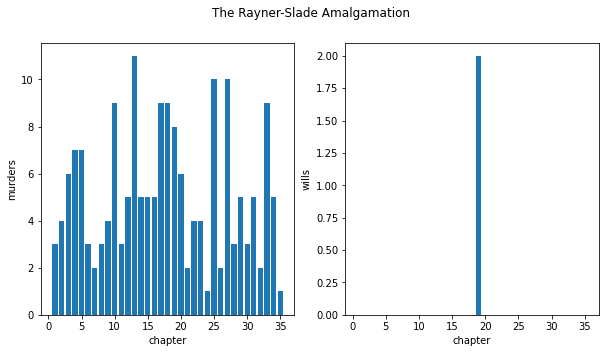

Chapter:1 MURDER: 2 Will: 0 MurderSimple: 1 WillSimple:0
Chapter:2 MURDER: 1 Will: 0 MurderSimple: 0 WillSimple:3
Chapter:3 MURDER: 5 Will: 1 MurderSimple: 1 WillSimple:1
Chapter:4 MURDER: 11 Will: 0 MurderSimple: 9 WillSimple:1
Chapter:5 MURDER: 13 Will: 0 MurderSimple: 8 WillSimple:0
Chapter:6 MURDER: 16 Will: 0 MurderSimple: 10 WillSimple:0
Chapter:7 MURDER: 9 Will: 0 MurderSimple: 4 WillSimple:0
Chapter:8 MURDER: 5 Will: 0 MurderSimple: 3 WillSimple:1
Chapter:9 MURDER: 7 Will: 2 MurderSimple: 3 WillSimple:2
Chapter:10 MURDER: 6 Will: 0 MurderSimple: 3 WillSimple:0
Chapter:11 MURDER: 10 Will: 9 MurderSimple: 4 WillSimple:9
Chapter:12 MURDER: 3 Will: 1 MurderSimple: 1 WillSimple:2
Chapter:13 MURDER: 1 Will: 0 MurderSimple: 0 WillSimple:2
Chapter:14 MURDER: 11 Will: 0 MurderSimple: 6 WillSimple:2
Chapter:15 MURDER: 5 Will: 0 MurderSimple: 3 WillSimple:1
Chapter:16 MURDER: 7 Will: 0 MurderSimple: 4 WillSimple:1
Chapter:17 MURDER: 13 Will: 0 MurderSimple: 6 WillSimple:1
Chapter:18 MURDE

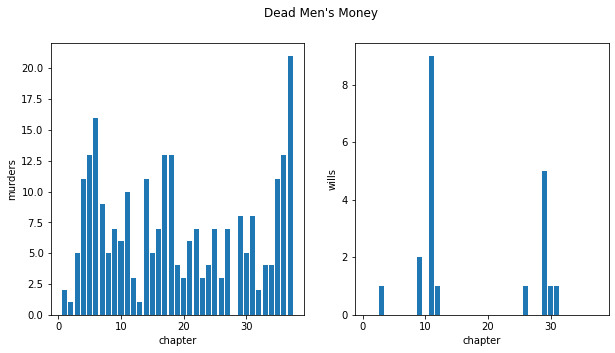

In [ ]:
####---------------------Add some graphs to show results---------------------
for book in books:
  murderData = []
  willData = []
#  if book.title != "The Talleyrand Maxim":
#    continue
  murder = countMurderByChapter(book)
  murderSimple = countByChapter(book.find("murder"))

  will = countWillByChapter(book)
  willSimple = countByChapter(book.find("will"))
  for i in range(1,len(book.chapters)+1):
    murderData.append(murder[i])
    willData.append(will[i])
    print(f"Chapter:{i} MURDER: {murder[i]} Will: {will[i]} MurderSimple: {murderSimple[i]} WillSimple:{willSimple[i]}")
#  plt.bar(range(1,len(book.chapters)+1), murderData)
#  plt.show()
#  plt.bar(range(1,len(book.chapters)+1), willData)
#  plt.show()
  plt.rcParams['figure.figsize'] = (10,5)  # rc: run configuration
  plt.figure()
  plt.subplot(1,2,1)
  plt.bar(range(1,len(book.chapters)+1), murderData)
  plt.xlabel('chapter')
  plt.ylabel('murders')
  # plt.show()
  plt.subplot(1,2,2)
  plt.bar(range(1,len(book.chapters)+1), willData)
  plt.xlabel('chapter')
  plt.ylabel('wills')
  plt.suptitle('{}'.format(book.title))
  plt.show()